<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/Twitter%20US%20Airline%20Sentiment%20-%20NLP%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Kaggle Twitter US Airline Sentiment
  - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.utils import np_utils
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '../datasets/Tweets.csv'

2023-03-11 09:30:22.839640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
tweets = pd.read_csv(FILE_PATH, sep=',')
tweets = tweets[['text', 'airline_sentiment']]

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
TEST_SIZE = 0.1

(tweets_train, tweets_test,
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['airline_sentiment'],
                                                     test_size=TEST_SIZE, stratify=tweets['airline_sentiment'],
                                                     shuffle=True, random_state=SEED)

In [ ]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['airline_sentiment'])

y_train = np_utils.to_categorical(label_encoder.transform(sentiment_train))
y_test = np_utils.to_categorical(label_encoder.transform(sentiment_test))

In [ ]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [ ]:
counts = tweets.groupby(['airline_sentiment']).count()
counts.reset_index(inplace=True)

counts

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


In [ ]:
naive_baseline = counts[counts['airline_sentiment']=='negative']['text'].values[0] / counts['text'].sum()

naive_baseline

0.6269125683060109

In [ ]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 0.5317352220103514, 1: 1.5748285599031868, 2: 2.064516129032258}

In [ ]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy',
           Precision(name='precision'),
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

2023-03-11 09:32:28.106170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-11 09:32:28.106197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: snottingham
2023-03-11 09:32:28.106202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: snottingham
2023-03-11 09:32:28.106260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.8
2023-03-11 09:32:28.106275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.8
2023-03-11 09:32:28.106278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.8
2023-03-11 09:32:28.106501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

In [ ]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

2023-02-19 21:21:11.394653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-19 21:21:11.394681: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-19 21:21:11.394703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snottingham): /proc/driver/nvidia/version does not exist
2023-02-19 21:21:11.394944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
baseline = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ]
)

baseline._name = 'baseline'
baseline_initial_weights = baseline.get_weights()

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15003     
                                                                 
Total params: 15,003
Trainable params: 15,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 512
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [ ]:
learning_rate = 0.01

baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [ ]:
EPOCHS = 100
batch_size=512

baseline.set_weights(baseline_initial_weights)

baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

2023-03-11 09:33:30.431825: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 234240000 exceeds 10% of free system memory.


In [ ]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(baseline_scores[1]))
print('Recall (Validation): {:.2f}'.format(baseline_scores[2]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[3]))

Accuracy (Validation): 0.80 (Naive Baseline=0.63)
Precision (Validation): 0.83
Recall (Validation): 0.77
AUC (Validation): 0.92


In [ ]:
preds = trained_slp_model['model'].predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_val.argmax(axis=1), preds)))

Balanced Accuracy (Validation): 0.78 (baseline = 0.33)


In [ ]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

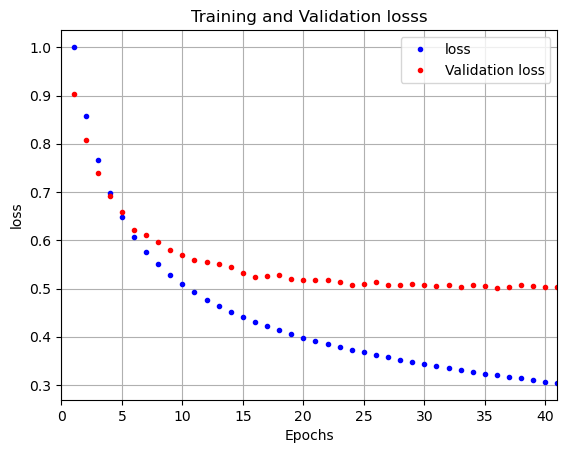

In [ ]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [ ]:

overfit = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

overfit_initial_weights = overfit.get_weights()
overfit._name = 'overfit'

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate = 0.0025

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

overfit.set_weights(overfit_initial_weights)

In [ ]:
EPOCHS = 100
batch_size=512

overfit.set_weights(overfit_initial_weights)

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

2023-03-11 09:35:05.437266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 234240000 exceeds 10% of free system memory.


In [ ]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(overfit_scores[1]))
print('Recall (Validation): {:.2f}'.format(overfit_scores[2]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[3]))

Accuracy (Validation): 0.77 (Naive Baseline = 0.63)
Precision (Validation): 0.77
Recall (Validation): 0.77
AUC (Validation): 0.85


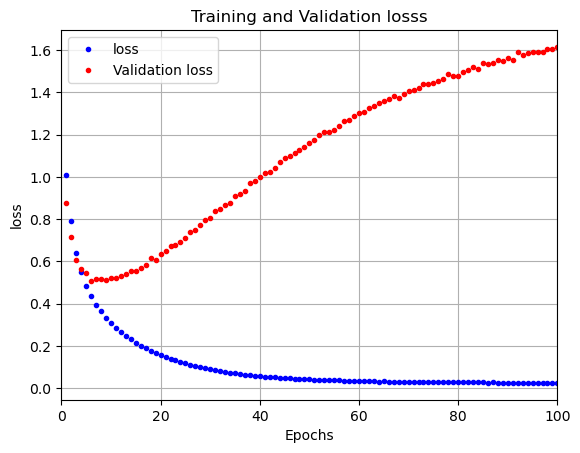

In [ ]:
plot_training_history(overfit_history, monitor='loss')

 ## Regularizing your model and tuning your hyperparameters

In [ ]:
# over-sized model - neural network architecture that can overfit the data
deep = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

deep._name = 'deep'

deep.summary()

Model: "deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [ ]:
wider = Sequential(
    [
        Dense(128, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

wider._name = 'wider'

wider.summary()

Model: "wider"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               640128    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 640,515
Trainable params: 640,515
Non-trainable params: 0
_________________________________________________________________


In [ ]:
deeper = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

deeper._name = 'deeper'

deeper.summary()

Model: "deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                320064    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 324,419
Trainable params: 324,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def cross_validation(X, y,
                     class_weight,
                     params, kfolds, epochs,
                     callbacks, seed=0) :
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)) :
        model = clone_model(params['model'])

        for layer in model.layers :
            if type(layer) == keras.layers.regularization.dropout.Dropout :
                layer.rate = params['dropout']

        model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']),
                      loss=LOSS_FUNC, metrics=METRICS)

        history = model.fit(X[train,:], y[train,:],
                            class_weight=class_weight,
                            batch_size=params['batch_size'], epochs=epochs,
                            validation_data=(X[validate,:], y[validate,:]),
                            callbacks=callbacks,
                            verbose=0)

        evaluation = model.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append( evaluation )

    return np.mean(evaluations, axis=0)

In [ ]:
def grid_search_cv(X, y,
                   class_weight,
                   search_space, cv,
                   epochs, callbacks=[], seed=0) :

    keys, values = zip(*search_space.items())

    kfolds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)

    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :

        scores = cross_validation(X, y, class_weight,
                                  params, kfolds, epochs,
                                  callbacks, seed)

        params['model'] = params['model']._name

        stats[str(params)] = scores

    return stats

In [ ]:
# our search space
params = {
    'model': [deep, wider, deeper],
    'dropout': [0.25, 0.5],
    'learning_rate': [0.0025, 0.005],
    'batch_size': [512]
}

EPOCHS = 500
KFOLDS = 5

In [ ]:
stats = grid_search_cv(X_train, y_train,
                       class_weight=CLASS_WEIGHT,
                       search_space=params, cv=KFOLDS, epochs=EPOCHS,
                       callbacks=[EARLY_STOP], seed=SEED)

2023-03-11 09:38:07.311029: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 187380000 exceeds 10% of free system memory.
2023-03-11 09:38:13.508979: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 187380000 exceeds 10% of free system memory.
2023-03-11 09:38:21.031183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 187400000 exceeds 10% of free system memory.


In [ ]:
def dict_to_dataframe(stats) :
    entries = []
    for key, value in stats.items() :
        entry = eval(key)

        metrics = ['accuracy', 'precision', 'recall', 'auc']
        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

In [ ]:
kfold_stats = dict_to_dataframe(stats)

kfold_stats.sort_values(by=['auc'], ascending=False).head(10)

,model,dropout,learning_rate,batch_size,accuracy,precision,recall,auc
10,deeper,0.50,0.0025,512,0.805874,0.824236,0.782240,0.916996
3,deep,0.50,0.0050,512,0.808333,0.830886,0.777869,0.916431
2,deep,0.50,0.0025,512,0.798224,0.824514,0.771448,0.916407
7,wider,0.50,0.0050,512,0.808470,0.827209,0.785383,0.916170
0,deep,0.25,0.0025,512,0.801913,0.823860,0.769945,0.915856
6,wider,0.50,0.0025,512,0.803689,0.825916,0.775410,0.915842
1,deep,0.25,0.0050,512,0.807923,0.826714,0.782104,0.915809
8,deeper,0.25,0.0025,512,0.806011,0.826123,0.781557,0.915366
11,deeper,0.50,0.0050,512,0.800820,0.821013,0.773770,0.914922
4,wider,0.25,0.0025,512,0.803962,0.827863,0.772814,0.914541


In [ ]:
# the best parameters by AUC are:
# model = deeper
# dropout = 0.5
# learning_rate = 0.0025
# batch_size = 512

In [ ]:
# optimal parameters are taken out from our k-fold grid-search stats
best_params = {
    'model': deeper,
    'dropout': 0.5,
    'learning_rate': 0.0025,
    'batch_size': 512
}

best_model = clone_model(best_params['model'])
best_model.layers[1] = best_params['dropout'] # dropout layer

best_model.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']),
                   loss=LOSS_FUNC, metrics=METRICS)

history = best_model.fit(X_train, y_train,
                         class_weight=CLASS_WEIGHT,
                         batch_size=best_params['batch_size'], epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=[EARLY_STOP],
                         verbose=0)

In [ ]:
validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))

Accuracy (Validation): 0.81 (Naive Baseline = 0.63)
Precision (Validation): 0.82
Recall (Validation): 0.79
AUC (Validation): 0.92


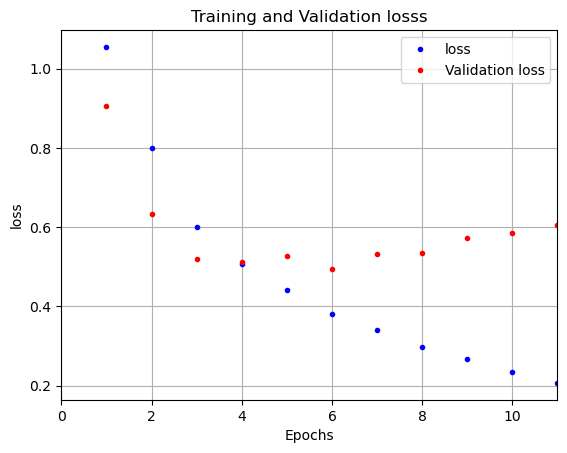

In [ ]:
plot_training_history(history, monitor='loss')

In [ ]:
test_scores = best_model.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('Precision (Test): {:.2f}'.format(test_scores[1]))
print('Recall (Test): {:.2f}'.format(test_scores[2]))
print('AUC (Test): {:.2f}'.format(test_scores[3]))

Accuracy (Test): 0.80 (Naive Baseline = 0.63)
Precision (Test): 0.81
Recall (Test): 0.78
AUC (Test): 0.91


In [ ]:
ALPHA = 0.001

l2exp = Sequential(
    [
        Dense(64, activation='relu', kernel_regularizer=l2(ALPHA), input_shape=(INPUT_DIMENSION,)),
        Dense(64, activation='relu', kernel_regularizer=l2(ALPHA), input_shape=(INPUT_DIMENSION,)),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

l2exp._name = 'l2exp'

l2exp.summary()

Model: "l2exp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                320064    
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 324,419
Trainable params: 324,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
l2exp.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']),
              loss=LOSS_FUNC, metrics=METRICS)

l2exp_history = l2exp.fit(X_train, y_train,
                          class_weight=CLASS_WEIGHT,
                          batch_size=best_params['batch_size'], epochs=EPOCHS,
                          validation_data=(X_val, y_val),
                          callbacks=[EARLY_STOP],
                          verbose=0)

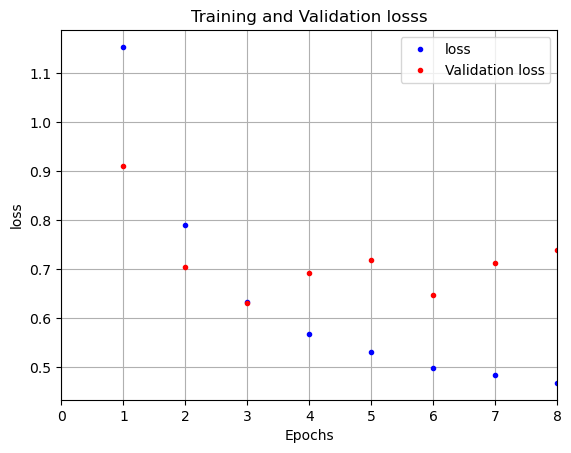

In [ ]:
plot_training_history(l2exp_history, monitor='loss')

In [ ]:
validation_scores = l2exp.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))

Accuracy (Validation): 0.81 (Naive Baseline = 0.63)
Precision (Validation): 0.84
Recall (Validation): 0.77
AUC (Validation): 0.92


In [ ]:
test_scores = l2exp.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('Precision (Test): {:.2f}'.format(test_scores[1]))
print('Recall (Test): {:.2f}'.format(test_scores[2]))
print('AUC (Test): {:.2f}'.format(test_scores[3]))

Accuracy (Test): 0.80 (Naive Baseline = 0.63)
Precision (Test): 0.83
Recall (Test): 0.76
AUC (Test): 0.91
